In [2]:
import keras
import os
import typing
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import math
import numpy as np
import cv2
import json
from pathlib import Path

Using TensorFlow backend.


In [3]:
#import all libraries
from PIL import Image, ImageOps,ImageFilter
#import cv2
import time
import argparse
from scipy import ndimage
from scipy import misc
%matplotlib inline
import readline
readline.parse_and_bind("tab: complete")
from scipy import ndimage
from multiprocessing.pool import ThreadPool

from urllib.request import Request, urlopen, HTTPError
import ssl

In [4]:
import os
import numpy as np
import argparse
from keras.models import Model
from PIL import Image, ImageOps,ImageFilter
import matplotlib.image as mpimg
import csv
from numpy import linalg
from pandas import HDFStore

In [5]:
import os
dir_litw =Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/resized_images_excluded_mscn2")



In [6]:
#Image processing for resizing images
def fix_aspect_ratio(img,expected_dimension):
    original_max_dim = max(float(img.size[0]),float(img.size[1]))
    original_min_dim = min(float(img.size[0]),float(img.size[1]))
    wpercent = (expected_dimension/float(original_max_dim))
    hsize = int((original_min_dim*float(wpercent)))
    new_im = img.resize((expected_dimension,hsize), Image.ANTIALIAS)
    return new_im

In [7]:
# Make square images
def make_square(img, min_size=120, fill_color=(0, 0, 0, 0)):
    x, y = img.size
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(img, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

In [8]:
# Sharpen the edges
from pylab import *
def sharpen_filter(img):
    sharp_im = img.filter(ImageFilter.SHARPEN)
    return sharp_im

In [9]:
import scipy.signal
def calculate_MSCN_val(img):
    C=3.0/255.0
    blurred_img=cv2.GaussianBlur(img, (7, 7), 1.166)
    blurred_sq = blurred_img * blurred_img 
    sigma = cv2.GaussianBlur(img * img, (7, 7), 1.166) 
    sigma = (sigma - blurred_sq) ** 0.5
    sigma = sigma + C
    MCSN_value = (img - blurred_img)/sigma
    return MCSN_value

In [10]:
from keras.models import load_model
from joblib import dump, load
import pickle
from sklearn.cluster import KMeans

#model = load('filename_22.joblib') 
model= load('./Models_embedding/filename_6272019_v1_search.joblib')
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[

In [11]:
import h5py

def Store_Image_Features_files(glob_path_complete_path,intermediate_layer_model,company_brand_name,folder_logo_num):
    
    df_feature_file_rows = pd.DataFrame(columns=['true_logo','logo_img_name','company_brand','features_list_count'])
    store_features_rows = pd.DataFrame(columns=['feature_list'])
    logo_imgs_stage = np.ndarray((1, 120, 120, 3), dtype=np.uint8)
    
    file_name= (os.listdir(glob_path_complete_path))
    
    
    index = 0
   

    features_img_rows=[]
    imageID=1
    score_folder=0
    for record_file in file_name:
        X_train_row =[]
        file_name_full=os.path.join(glob_path_complete_path,record_file)
        logo_imgs_stage = np.ndarray((1, 120, 120, 3), dtype=np.uint8)
        img_original = mpimg.imread(file_name_full)
        if imageID > 4:
            continue
        normalizedImg = cv2.normalize(img_original,None,0,1, cv2.NORM_MINMAX)
        logo_imgs_stage[0] = normalizedImg[:,:,:3]
        X_train_row.append(logo_imgs_stage)
        X_train=np.concatenate(X_train_row)
        feature_engg_data = intermediate_layer_model.predict(X_train)
        feature_engg_data=feature_engg_data/linalg.norm(feature_engg_data)
        data=feature_engg_data.flatten()
        row = pd.Series({'true_logo' :folder_logo_num,
                         'logo_img_name' :record_file,
                         'company_brand' :company_brand_name,
                         'features_list_count': imageID,})
        row_data=pd.Series({'feature_list':data,})
        df_feature_file_rows=df_feature_file_rows.append(row,ignore_index=True) 
        store_features_rows=store_features_rows.append(row_data,ignore_index=True)
        
        imageID = imageID+1
    
    
            
    return store_features_rows

In [12]:


def Store_Image_Features_folder(dir_litw):
    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer('dense_3').output)
    dir_name = Path("./Data_features")
    
   # query_path=Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/query")

    df_feature_list=[]
    folder_logo_num=0
    df_main_folder_path=[]
    df_folder_list=[]
    folders = ([name for name in sorted(os.listdir(dir_litw), key=str.casefold)]) # get all directories 
    folder_logo_num=0;
   
     
    for company_name in folders:
    #predict to get featured data
        glob_path_complete = Path(os.path.join(dir_litw,company_name))
        
        df_feature_list = Store_Image_Features_files(glob_path_complete,intermediate_layer_model,company_name,folder_logo_num)
        df_feature_list_2=df_feature_list.as_matrix()
        
        file_name = company_name+'.npy'
        file_name_full = os.path.join(dir_name,file_name)
        np.save(file_name_full,df_feature_list)
        df_main_folder_path.append(glob_path_complete)
        df_folder_list.append(company_name)
        folder_logo_num=folder_logo_num+1
       
    # directory for storing extracted features
  
        
    
     
    
    np.save('output_6262019_folder2.npy',df_folder_list)
    np.save('output_6262019_folder_path2.npy',df_main_folder_path)
    
    return df_folder_list,df_main_folder_path,intermediate_layer_model

In [13]:
df_folder_list,df_main_folder_path,intermediate_layer_model = Store_Image_Features_folder(dir_litw)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [14]:
def Make_Fake_Images_Sharp():
    glob_path_complete_path = Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/query_fake")
    mod_full_dir = Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/query_resized")
    index_image=1
    expected_dimension=120
    for filename_logo in glob_path_complete_path.glob('**/*.png'):
         with open(filename_logo) as imagefile:
            image_original = Image.open(filename_logo)
            dir_name,file_orig_name = os.path.split(filename_logo)
           
            img_mod_name = 'Fake-AB-'+ str(index_image) +'.png'
            
            os.makedirs(mod_full_dir, exist_ok=True)
            path_to_image = os.path.join(mod_full_dir,img_mod_name)             
                  
           

            image_aspect=fix_aspect_ratio(image_original,expected_dimension)
            
            img_new = make_square(image_aspect)
            
            sharpen_image=sharpen_filter(img_new)
            im_med = ndimage.median_filter(sharpen_image, 3)
            #norm_image=cv2.normalize(im_med,None,0,1, cv2.NORM_MINMAX)
            file_name=os.path.join(mod_full_dir,img_mod_name)
            print(file_name)
            misc.imsave(file_name, im_med)
            index_image=index_image+1

In [15]:
Make_Fake_Images_Sharp()

c:\Users\Sanyogita\Documents\Insight\projects\Trademark_RADAR\large_data\query_resized\Fake-AB-1.png
c:\Users\Sanyogita\Documents\Insight\projects\Trademark_RADAR\large_data\query_resized\Fake-AB-2.png
c:\Users\Sanyogita\Documents\Insight\projects\Trademark_RADAR\large_data\query_resized\Fake-AB-3.png
c:\Users\Sanyogita\Documents\Insight\projects\Trademark_RADAR\large_data\query_resized\Fake-AB-4.png


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [16]:
def Get_average_score_ranking(df_average_score_list,df_folder_list,df_main_folder_path):
    
    scores = np.array(df_average_score_list)
   
    rank_ID = np.argsort(scores)[:-11:-1]
    rank_score = scores[rank_ID]

    maxres=10
    query_path=Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/query")
    query_file_name = (os.listdir(query_path))
    query_image_full_path = os.path.join(query_path,query_file_name[0])
    query_image_show = mpimg.imread(query_image_full_path)
    plt.title("Query Image")
    plt.imshow(query_image_show)
    plt.show()
    #print(scores)
    
    df_main_folder_path = [(df_main_folder_path[index_2]) for i_2,index_2 in enumerate(rank_ID[0:maxres])]
    scores_list = [(scores[index_3]) for i_3,index_3 in enumerate(rank_ID[0:maxres])]
    print("top %d images in order are: " %maxres, df_main_folder_path)
    print(scores_list[0])

    # show top #maxres retrieved result one by one
    for i,im_folder_name in enumerate(df_main_folder_path):
        #print(df_main_folder_path[i])
        mod_folder_name_head,mod_folder_name_tail = os.path.split(im_folder_name)
        length_folder = len(mod_folder_name_tail)-4
        mod_folder_name = mod_folder_name_tail[:length_folder]
        dir_litw_folder = os.path.join(dir_litw,mod_folder_name)
        
       
        im_file=os.listdir(dir_litw_folder)
        
        im_path_file_full=os.path.join(dir_litw_folder,im_file[0])
        im_path_file_full=im_path_file_full
        image = mpimg.imread((im_path_file_full))
        plt.title(im_file[0])
        plt.imshow(image)
        plt.show()


In [17]:
def Get_Image_Features_files(file_record,intermediate_layer_model,query_feature):
    logo_imgs_stage = np.ndarray((1, 120, 120, 3), dtype=np.uint8)
    
    
    length_file = len(file_record)
    
    i_index = 0
   
    record_file_rows=[]
    features_img_rows=[]
    imageID=1

    score_folder=0
    for index in range(length_file):
        X_train_row =[]
        
        feature_engg_data = (file_record[i_index][0])

        score_file=cosine_distance(query_feature, feature_engg_data.T) 
       
        score_folder=score_folder+score_file
                
        i_index = i_index+1
        
    average_score= score_folder/length_file
    
    return average_score


In [25]:
def Get_feature_score(intermediate_layer_model):

    dir_litw_features =Path("./Data_features")
    query_path=Path("c:/Users/Sanyogita/Documents/Insight/projects/Trademark_RADAR/large_data/query")

    df_average_score_list=[]
    folder_logo_num=0
    df_main_folder_path=[]
    
    File_names = ([name for name in sorted(os.listdir(dir_litw_features), key=str.casefold)]) # get all directories 
    
    folder_logo_num=0;
    query_features=Extract_query_img_feature(query_path)
    for file_features_list in File_names:
    #predict to get featured data
        if file_features_list == '.ipynb_checkpoints':
            continue
        File_name_full = os.path.join(dir_litw_features,file_features_list)
        file_features_record = np.load(File_name_full)
        
        df_average_score_list.append(Get_Image_Features_files(file_features_record,intermediate_layer_model,query_features))
        df_main_folder_path.append(File_name_full)
        folder_logo_num=folder_logo_num+1
        
    return df_average_score_list,df_main_folder_path

In [28]:
df_average_score_list,df_main_folder_path_new = Get_feature_score(intermediate_layer_model)


[[0.06217581 0.01525627 0.0394343  ... 0.03603956 0.05167792 0.01843709]]
[[0.6412972  0.24029349 0.9770901  ... 2.0459008  0.         0.        ]]
[[0.03642564 0.         0.00534819 ... 0.06510917 0.02671252 0.        ]]
[[0.6412972  0.24029349 0.9770901  ... 2.0459008  0.         0.        ]]
[[0.04134189 0.         0.02492221 ... 0.05279202 0.07135487 0.00401364]]
[[0.6412972  0.24029349 0.9770901  ... 2.0459008  0.         0.        ]]
[[0.         0.         0.01366341 ... 0.00087956 0.07653447 0.02721654]]
[[0.6412972  0.24029349 0.9770901  ... 2.0459008  0.         0.        ]]
[[0.         0.         0.06271637 ... 0.04448286 0.02090389 0.0220631 ]]
[[0.6412972  0.24029349 0.9770901  ... 2.0459008  0.         0.        ]]
[[0.05356349 0.0174234  0.06274591 ... 0.04180385 0.02456116 0.01632584]]
[[0.6412972  0.24029349 0.9770901  ... 2.0459008  0.         0.        ]]
[[0.00438517 0.00504203 0.06128028 ... 0.0448143  0.03601848 0.02313137]]
[[0.6412972  0.24029349 0.9770901  ...

[[0.02683862 0.         0.01068672 ... 0.02901072 0.04245957 0.0272331 ]]
[[0.6412972  0.24029349 0.9770901  ... 2.0459008  0.         0.        ]]
[[0.         0.02597324 0.06557889 ... 0.01620909 0.05226994 0.03561645]]
[[0.6412972  0.24029349 0.9770901  ... 2.0459008  0.         0.        ]]
[[0.02211609 0.0144285  0.00300803 ... 0.03346704 0.05196247 0.0136435 ]]
[[0.6412972  0.24029349 0.9770901  ... 2.0459008  0.         0.        ]]
[[0.02472184 0.01539988 0.02950373 ... 0.08120237 0.07327592 0.00903461]]
[[0.6412972  0.24029349 0.9770901  ... 2.0459008  0.         0.        ]]
[[0.01497324 0.05001502 0.05074418 ... 0.03995889 0.03203696 0.00011992]]
[[0.6412972  0.24029349 0.9770901  ... 2.0459008  0.         0.        ]]
[[3.9689985e-05 2.4077406e-02 2.3382867e-02 ... 4.0899429e-02
  9.5386663e-03 4.6740607e-03]]
[[0.6412972  0.24029349 0.9770901  ... 2.0459008  0.         0.        ]]
[[0.03170019 0.         0.06167302 ... 0.02037708 0.01881098 0.0404396 ]]
[[0.6412972  0.240

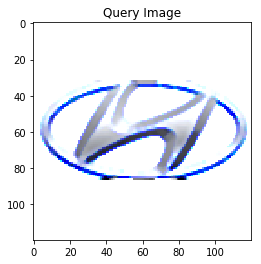

top 10 images in order are:  ['Data_features\\Mod-hyundai-symbol.npy', 'Data_features\\Mod-toyota.npy', 'Data_features\\Mod-honda-symbol.npy', 'Data_features\\Mod-lexus-symbol.npy', 'Data_features\\Mod-bmw.npy', 'Data_features\\Mod-vw.npy', 'Data_features\\Mod-pepsi-symbol.npy', 'Data_features\\Mod-mercedes.npy', 'Data_features\\Mod-rolex-symbol.npy', 'Data_features\\Mod-bosch-symbol.npy']
0.7506941705942154


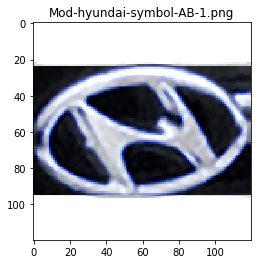

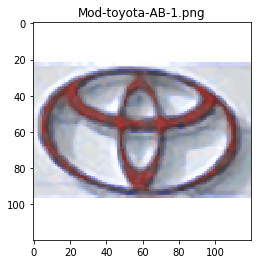

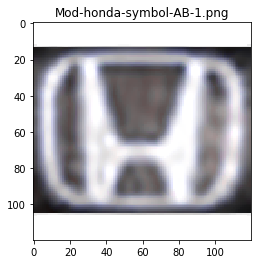

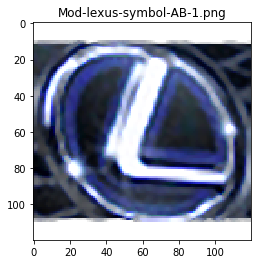

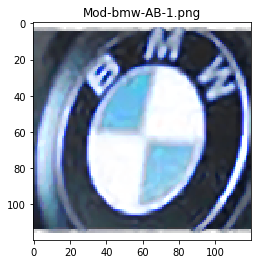

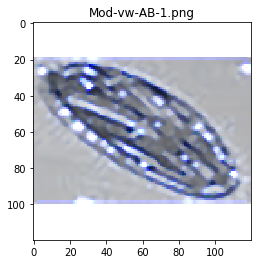

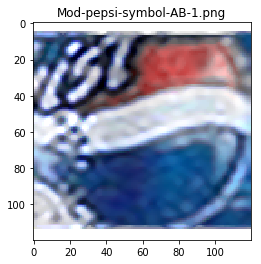

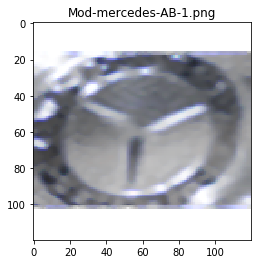

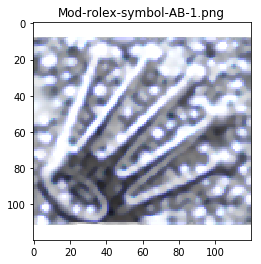

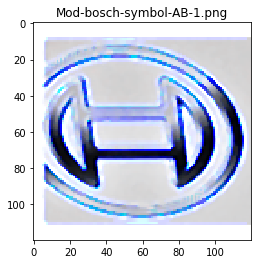

In [29]:
Get_average_score_ranking(df_average_score_list,df_folder_list,df_main_folder_path_new)

In [27]:
def Extract_query_img_feature(dir_litw):
    

    df_list=[]
    imageID=1
 
    index = 0
    X_train_row =[]
    logo_imgs_stage = np.ndarray((1, 120, 120, 3), dtype=np.uint8)
    glob_path_complete_path=Path(dir_litw)
    file_name= os.listdir(glob_path_complete_path)
    file_name_full=os.path.join(glob_path_complete_path,file_name[0])
    
    img_original = mpimg.imread(file_name_full)
    normalizedImg = cv2.normalize(img_original,None,0,1, cv2.NORM_MINMAX)
    logo_imgs_stage[index] = normalizedImg[:,:,:3]
    X_train_row.append(logo_imgs_stage)
    X_train=np.concatenate(X_train_row)
    feature_engg_data = intermediate_layer_model.predict(X_train)


    imageID = imageID+1
    return  feature_engg_data

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
def cosine_distance(query_feature, stored_feature):
    stored_feature = stored_feature.reshape(1, -1)
    print(stored_feature)
    query_feature = query_feature.reshape(1, -1)
    print(query_feature)
    result=cosine_similarity(stored_feature,query_feature)
    #result = 1 - spatial.distance.cosine(stored_feature, query_feature)
    return result[0][0]